In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Set2')


## Read the data

In [109]:
df = pd.read_csv('../data/train_data.csv')
# create a new column called weightOverHeightSquared
df['weightOverHeightSquared'] = df['Weight'] / df['Height'] ** 2

numerical_features = ['Weight', 'Height', 'Age', 'Meal_Count', 'Phys_Act', 'Water_Consump', 'weightOverHeightSquared']
categorical_features = ['Smoking', 'Alcohol_Consump', 'Transport']
target = 'Body_Level'

df = df[numerical_features + categorical_features + [target]]


## Explore the features

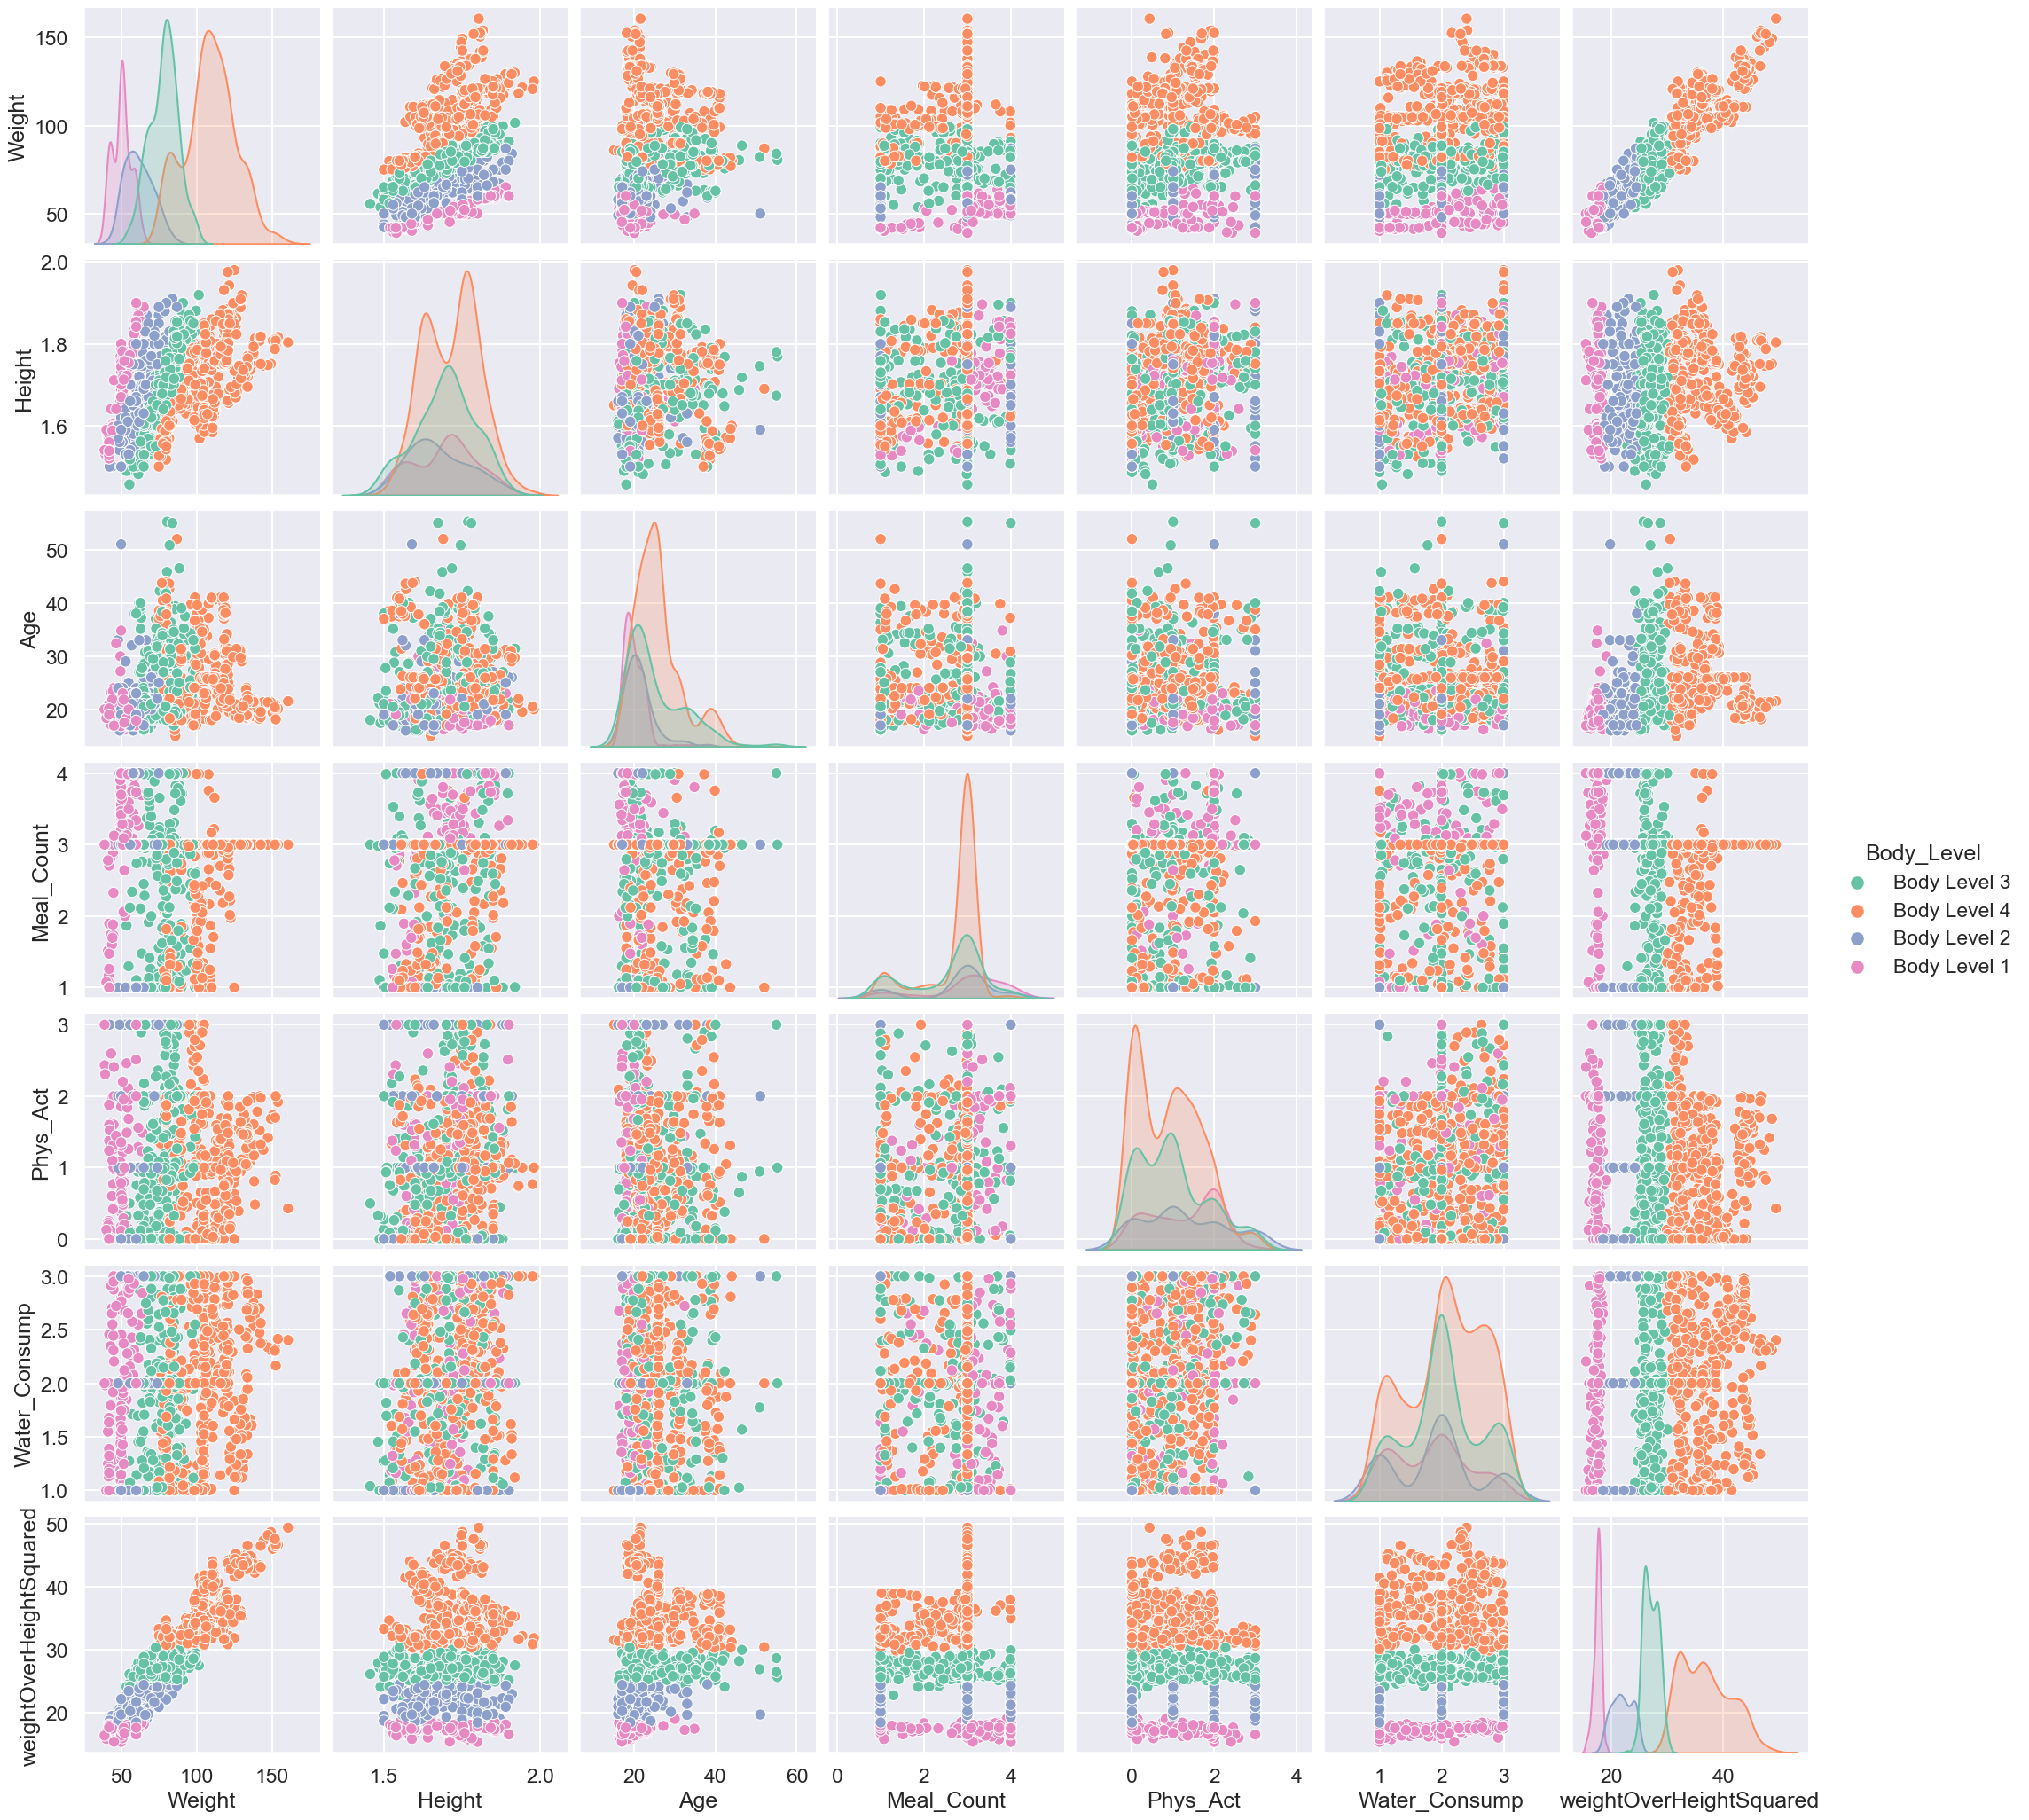

In [209]:
features = numerical_features + categorical_features
# relationship between features
sns.pairplot(df[numerical_features + categorical_features + [target]], hue=target, palette='Set2', diag_kind='kde', height=3)
plt.show()


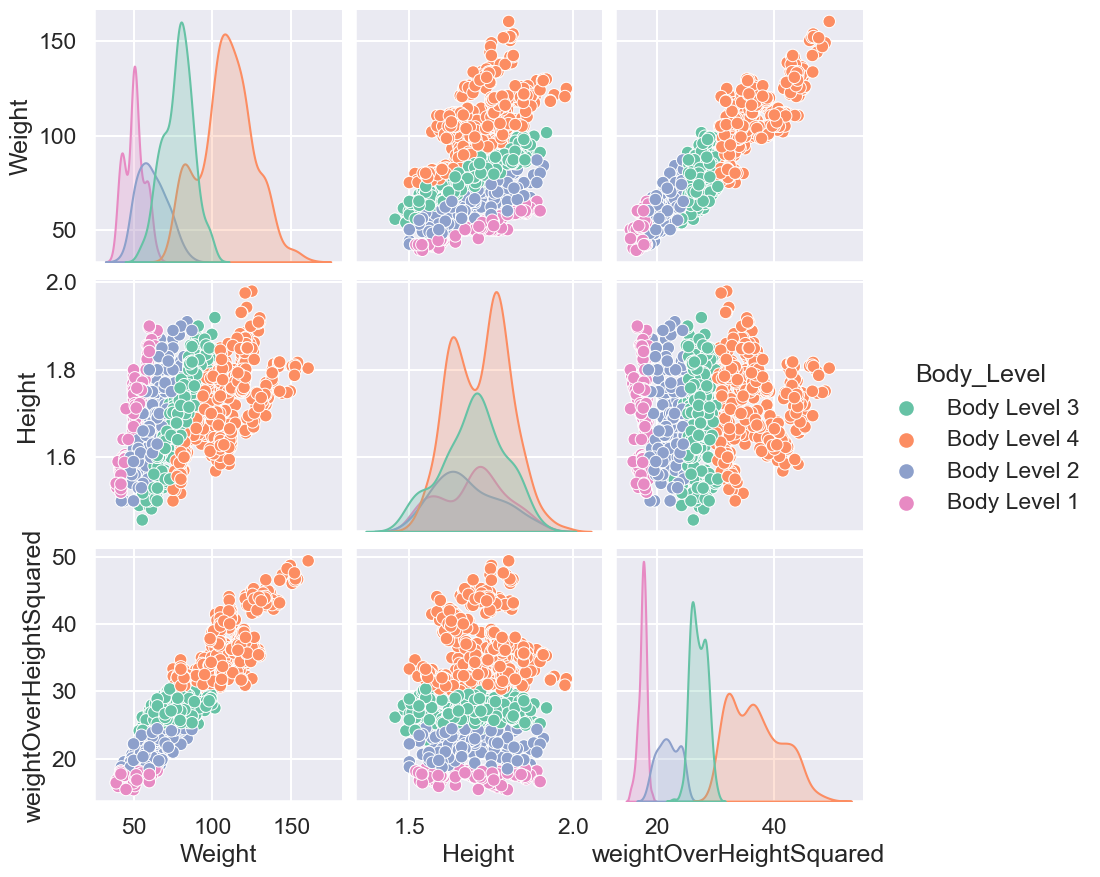

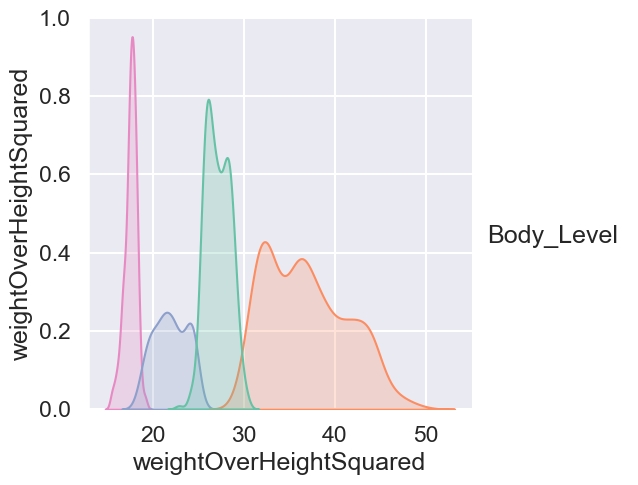

In [218]:
# relationship between features
sns.pairplot(df[['Weight', 'Height', 'weightOverHeightSquared', 'Body_Level']], hue=target, palette='Set2', diag_kind='kde', height=3)
plt.show()

# show the distribution of the weightOverHeightSquared feature with respect to the target
sns.pairplot(df[['weightOverHeightSquared', 'Body_Level']], hue=target, palette='Set2', diag_kind='kde', height=5)
plt.show()


Body_Level
Body Level 1    17.481547
Body Level 2    21.879882
Body Level 3    27.068681
Body Level 4    36.854733
Name: weightOverHeightSquared, dtype: float64
Body_Level
Body Level 1    17.578549
Body Level 2    21.801897
Body Level 3    26.989619
Body Level 4    36.320332
Name: weightOverHeightSquared, dtype: float64
Body_Level
Body Level 1    15.432099
Body Level 2    18.518519
Body Level 3    22.826739
Body Level 4    29.911958
Name: weightOverHeightSquared, dtype: float64


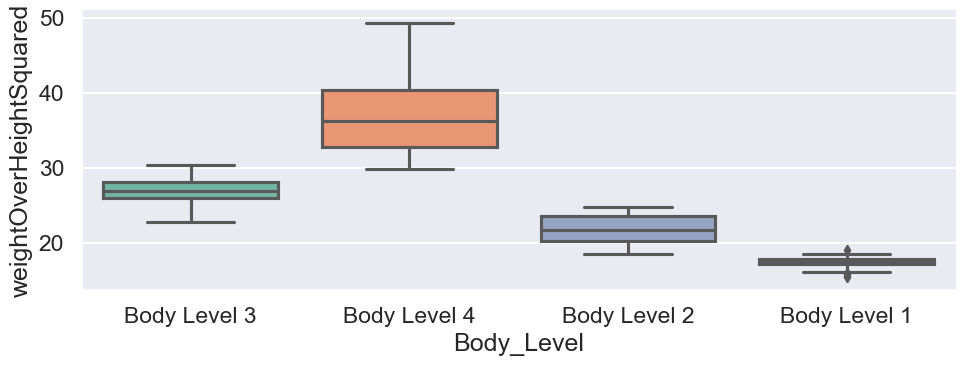

In [219]:

# Show a graph of the relationship between bode level and weightOverHeight
sns.catplot(x='Body_Level', y='weightOverHeightSquared', data=df, kind='box', height=4, aspect=2.5)

# print the mean of weightOverHeightSquared for each body level
print(df.groupby('Body_Level')['weightOverHeightSquared'].mean())
print(df.groupby('Body_Level')['weightOverHeightSquared'].median())
print(df.groupby('Body_Level')['weightOverHeightSquared'].min())

## Normalize the data

In [112]:
# # encode categorical features
# df = pd.get_dummies(df, columns=categorical_features)

# # normalize all features
# for feature in list(df.columns):
#     if feature == target:
#         continue
#     df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
# df.head()

## Prepare the data

In [113]:
X = df.drop('Body_Level', axis=1) # x contains all features except the target

# take the weight and height columns only
# X = X[['Weight', 'Height']]
X = X[['weightOverHeightSquared']]
y = df['Body_Level'] # y contains only the target
y = y.map({'Body Level 1': 0, 'Body Level 2': 1, 'Body Level 3': 2, 'Body Level 4': 3}) # encode target to numerical values
formatter = plt.FuncFormatter(lambda val, loc: ['Body Level 1', 'Body Level 2', 'Body Level 3', 'Body Level 4'][val]) # used to format the y axis ticks


## Conclusions
From the previous data exploration, we noticed that the data follows a certain equation. We undergone some research and found that it follows what is called a BMI(Body Mass Index) equation. The equation is as follows: $$BMI = \frac{weight}{height^2}$$

| Body Level            | Health Implications                                                                                                         |
| -------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| Underweight (<18.5)  | Increased risk of health problems such as osteoporosis, heart disease, and diabetes                                         |
| Normal (18.5-24.9)   | Healthy body weight                                                                                                         |
| Overweight (25-29.9) | Increased risk of health problems such as heart disease, stroke, type 2 diabetes, and certain types of cancer               |
| Obesity (30+)        | Significantly increased risk of health problems such as heart disease, stroke, type 2 diabetes, and certain types of cancer |

## Create a model

In [187]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=[18, 22, 30]):
        self.threshold = threshold
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        # convert x to numpy array
        X = np.array(X)
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if X[i][0] < self.threshold[0]:
                y_pred[i] = 0
            elif X[i][0] < self.threshold[1]:
                y_pred[i] = 1
            elif X[i][0] < self.threshold[2]:
                y_pred[i] = 2
            else:
                y_pred[i] = 3
        return y_pred
    


## Train the model

In [222]:
# Use the global BMI thresholds
globalThresholds = [18.5, 24.9, 29.9]

# calc the min value of weightOverHeightSquared for each body level
minVal = df.groupby('Body_Level')['weightOverHeightSquared'].min().tolist()
print (minVal)

# calc the 25th percentile of weightOverHeightSquared for each body level
q25 = df.groupby('Body_Level')['weightOverHeightSquared'].quantile(0.25).tolist()
print (q25)

# calc the mean value of weightOverHeightSquared for each body level
meanVal = df.groupby('Body_Level')['weightOverHeightSquared'].mean().tolist()
print (meanVal)

# create a list of thresholds
thresholds = minVal[1:]
# create a pipeline with the custom classifier
clf =  ThresholdClassifier(globalThresholds)

# Evaluate the model 
cv_results = cross_validate(clf, X, y, cv=10, scoring=['f1_macro', 'accuracy', 'f1_micro'])
print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())


[15.432098765432098, 18.51851851851852, 22.826738618008303, 29.911958308167144]
[17.16600909125834, 20.319814650166933, 25.961436275712682, 32.7695008370817]
[17.481547475205552, 21.87988177486076, 27.068680864424195, 36.85473300635413]
accuracy:  0.9864549209514315
f1_macro:  0.982450234501931
f1_micro:  0.9864549209514315
